In [1]:
from __future__ import annotations

In [2]:
from IPython.display import display, HTML
display(HTML('<style>.container { width:100% !important; }</style>'))

In [3]:
import os
import datetime
import numpy as np
import sklearn.metrics
import tensorflow as tf
import sklearn.datasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import seaborn as sns
sns.set_style('dark')
sns.set(rc={'figure.figsize': (10, 10), 'axes.grid': False})

2024-05-17 12:04:02.214365: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-17 12:04:02.998547: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-17 12:04:04.597267: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except:
        pass

2024-05-17 12:04:09.865011: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-17 12:04:10.143458: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-17 12:04:10.143551: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [5]:
rng = np.random.default_rng()

In [6]:
def plot_grid(X, ncols=2, nrows=2, figsize=(10, 10), hide_axes=True):
    fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)
    imgs = X[rng.choice(np.arange(X.shape[0]), size=ax.shape)].reshape(*ax.shape, 28, 28)
    for i in range(ax.shape[0]):
        for j in range(ax.shape[1]):
            ax[i, j].imshow(imgs[i, j], cmap='gray')
            if hide_axes:
                ax[i, j].get_xaxis().set_visible(False)
                ax[i, j].get_yaxis().set_visible(False)

In [7]:
def plot_grid_and_label(X, y, model, ncols=2, nrows=2, figsize=(10, 10), hide_axes=True, flatten_image=True, label_description=None):
    fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)
    idx = rng.choice(np.arange(X.shape[0]), size=ax.shape)
    imgs, labels = X[idx], y[idx]
    inputs = imgs.reshape(-1, *imgs.shape[2:])

    if flatten_image:
        inputs = inputs.reshape(nrows * ncols, -1)

    map_label = (lambda x: x) if label_description is None else (lambda x: label_description[x])

    preds = np.argmax(tf.nn.softmax(model.predict(inputs)), axis=-1).reshape(nrows, ncols)
    for i in range(ax.shape[0]):
        for j in range(ax.shape[1]):
            ax[i, j].imshow(imgs[i, j], cmap='gray')
            ax[i, j].set_title(f'label: {map_label(labels[i, j])}, prediction: {map_label(preds[i, j])}')
            if hide_axes:
                ax[i, j].get_xaxis().set_visible(False)
                ax[i, j].get_yaxis().set_visible(False)

In [8]:
label_description = [
     'A',   'I',   'U',  'E',  'O',
    'KA',  'KI',  'KU', 'KE', 'KO',
    'SA', 'SHI',  'SU', 'SE', 'SO',
    'TA', 'CHI', 'TSU', 'TE', 'TO',
    'NA',  'NI',  'NU', 'NE', 'NO',
    'HA',  'HI',  'FU', 'HE', 'HO',
    'MA',  'MI',  'MU', 'ME', 'MO',
    'YA',         'YU',       'YO',
    'RA',  'RI',  'RU', 'RE', 'RO',
    'WA',  'II',        'EE', 'WO',
     'N',  'IT'
]

In [13]:
counts = { j: np.sum(y_train == i) for i, j in enumerate(label_description) }

In [14]:
counts # what to do with imbalanced classes?

{'A': 5258,
 'I': 5275,
 'U': 5245,
 'E': 707,
 'O': 5236,
 'KA': 5255,
 'KI': 5198,
 'KU': 5222,
 'KE': 4138,
 'KO': 5263,
 'SA': 5253,
 'SHI': 5327,
 'SU': 5253,
 'SE': 3643,
 'SO': 3392,
 'TA': 5283,
 'CHI': 2256,
 'TSU': 5243,
 'TE': 5229,
 'TO': 5285,
 'NA': 5270,
 'NI': 5277,
 'NU': 1824,
 'NE': 2106,
 'NO': 5250,
 'HA': 5219,
 'HI': 4462,
 'FU': 5230,
 'HE': 5225,
 'HO': 1782,
 'MA': 5279,
 'MI': 2701,
 'MU': 1490,
 'ME': 2999,
 'MO': 5239,
 'YA': 5275,
 'YU': 1371,
 'YO': 5217,
 'RA': 5220,
 'RI': 5173,
 'RU': 5196,
 'RE': 5254,
 'RO': 1866,
 'WA': 2061,
 'II': 372,
 'EE': 327,
 'WO': 5213,
 'N': 5248,
 'IT': 3077}

In [9]:
X, y = sklearn.datasets.fetch_openml('Kuzushiji-49', version=1, return_X_y=True, as_frame=False, parser='auto')

In [10]:
y = np.array(list(map(int, y)))
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [11]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(203184, 784) (67728, 784) (203184,) (67728,)


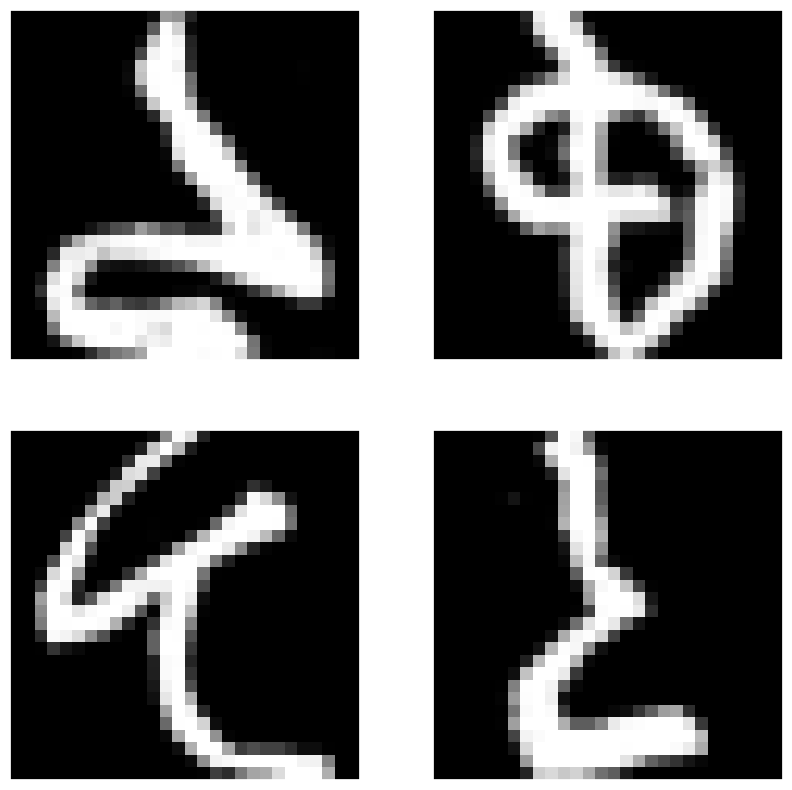

In [12]:
plot_grid(X_train)

## Flattened images
Use Dense layers

In [ ]:
# create train and validation datasets, these datasets should use flattened images

In [13]:
X_val = X_train[-40000:]
y_val = y_train[-40000:]
X_train = X_train[:-40000]
y_train = y_train[:-40000]

In [14]:
print(X_train.shape, X_val.shape)

(163184, 784) (40000, 784)


In [15]:
sample_weight = np.ones(shape=(len(y_train),))
sample_weight[y_train == 3] = 2.
sample_weight[y_train == 22] = 1.3
sample_weight[y_train == 29] = 1.3
sample_weight[y_train == 32] = 1.3
sample_weight[y_train == 36] = 1.3
sample_weight[y_train == 42] = 1.3
sample_weight[y_train == 43] = 1.3
sample_weight[y_train == 44] = 2.
sample_weight[y_train == 45] = 2.

In [21]:
# dataset = tf.data.Dataset.zip((
#     tf.data.Dataset.from_tensor_slices(X_train),
#     tf.data.Dataset.from_tensor_slices(y_train)
# ))

# dataset = dataset.shuffle(buffer_size=1024).batch(64)

dataset = tf.data.Dataset.from_tensor_slices(
    (X_train, y_train, sample_weight))
dataset = dataset.shuffle(buffer_size=1024).batch(64)

val_dataset = tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices(X_val),
    tf.data.Dataset.from_tensor_slices(y_val)
)).batch(64)

test_dataset = tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices(X_test),
    tf.data.Dataset.from_tensor_slices(y_test)
)).batch(64)

2024-05-15 12:51:17.132118: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-15 12:51:17.132325: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-15 12:51:17.132359: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-15 12:51:19.154686: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-15 12:51:19.155339: I external/local_xla/xla/stream_executor

In [22]:
dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 784), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [23]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 784), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [24]:
# create model, this model should accept a flattened image
inputs = tf.keras.layers.Input((784, ), dtype=tf.float32, name='inputs')
x = tf.keras.layers.Dense(512, activation='relu', name='flayr')(inputs) 
x = tf.keras.layers.BatchNormalization(name='bn1')(x)
x = tf.keras.layers.Dropout(0.3, name='drop1')(x)
x = tf.keras.layers.Dense(256, activation='relu', name='twlayr')(x)
x = tf.keras.layers.BatchNormalization(name='bn2')(x)
x = tf.keras.layers.Dropout(0.5, name='drop2')(x)
x = tf.keras.layers.Dense(128, activation='relu', name='thlayr')(x)
x = tf.keras.layers.BatchNormalization(name='bn3')(x)
x = tf.keras.layers.Dense(64, activation='relu', name='frlayr')(x)
x = tf.keras.layers.Dense(49, name='prediction')(x)
model_f = tf.keras.Model(inputs=inputs, outputs=x, name='k49')

In [25]:
model_f.summary()

Model: "k49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inputs (InputLayer)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flayr (Dense)                   │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 512)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ twlayr (Dense)                  │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ thlayr (Dense)                  │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ frlayr (Dense)                  │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ prediction (Dense)              │ (None, 49)             │         3,185 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 581,169 (2.22 MB)

 Trainable params: 579,377 (2.21 MB)

 Non-trainable params: 1,792 (7.00 KB)

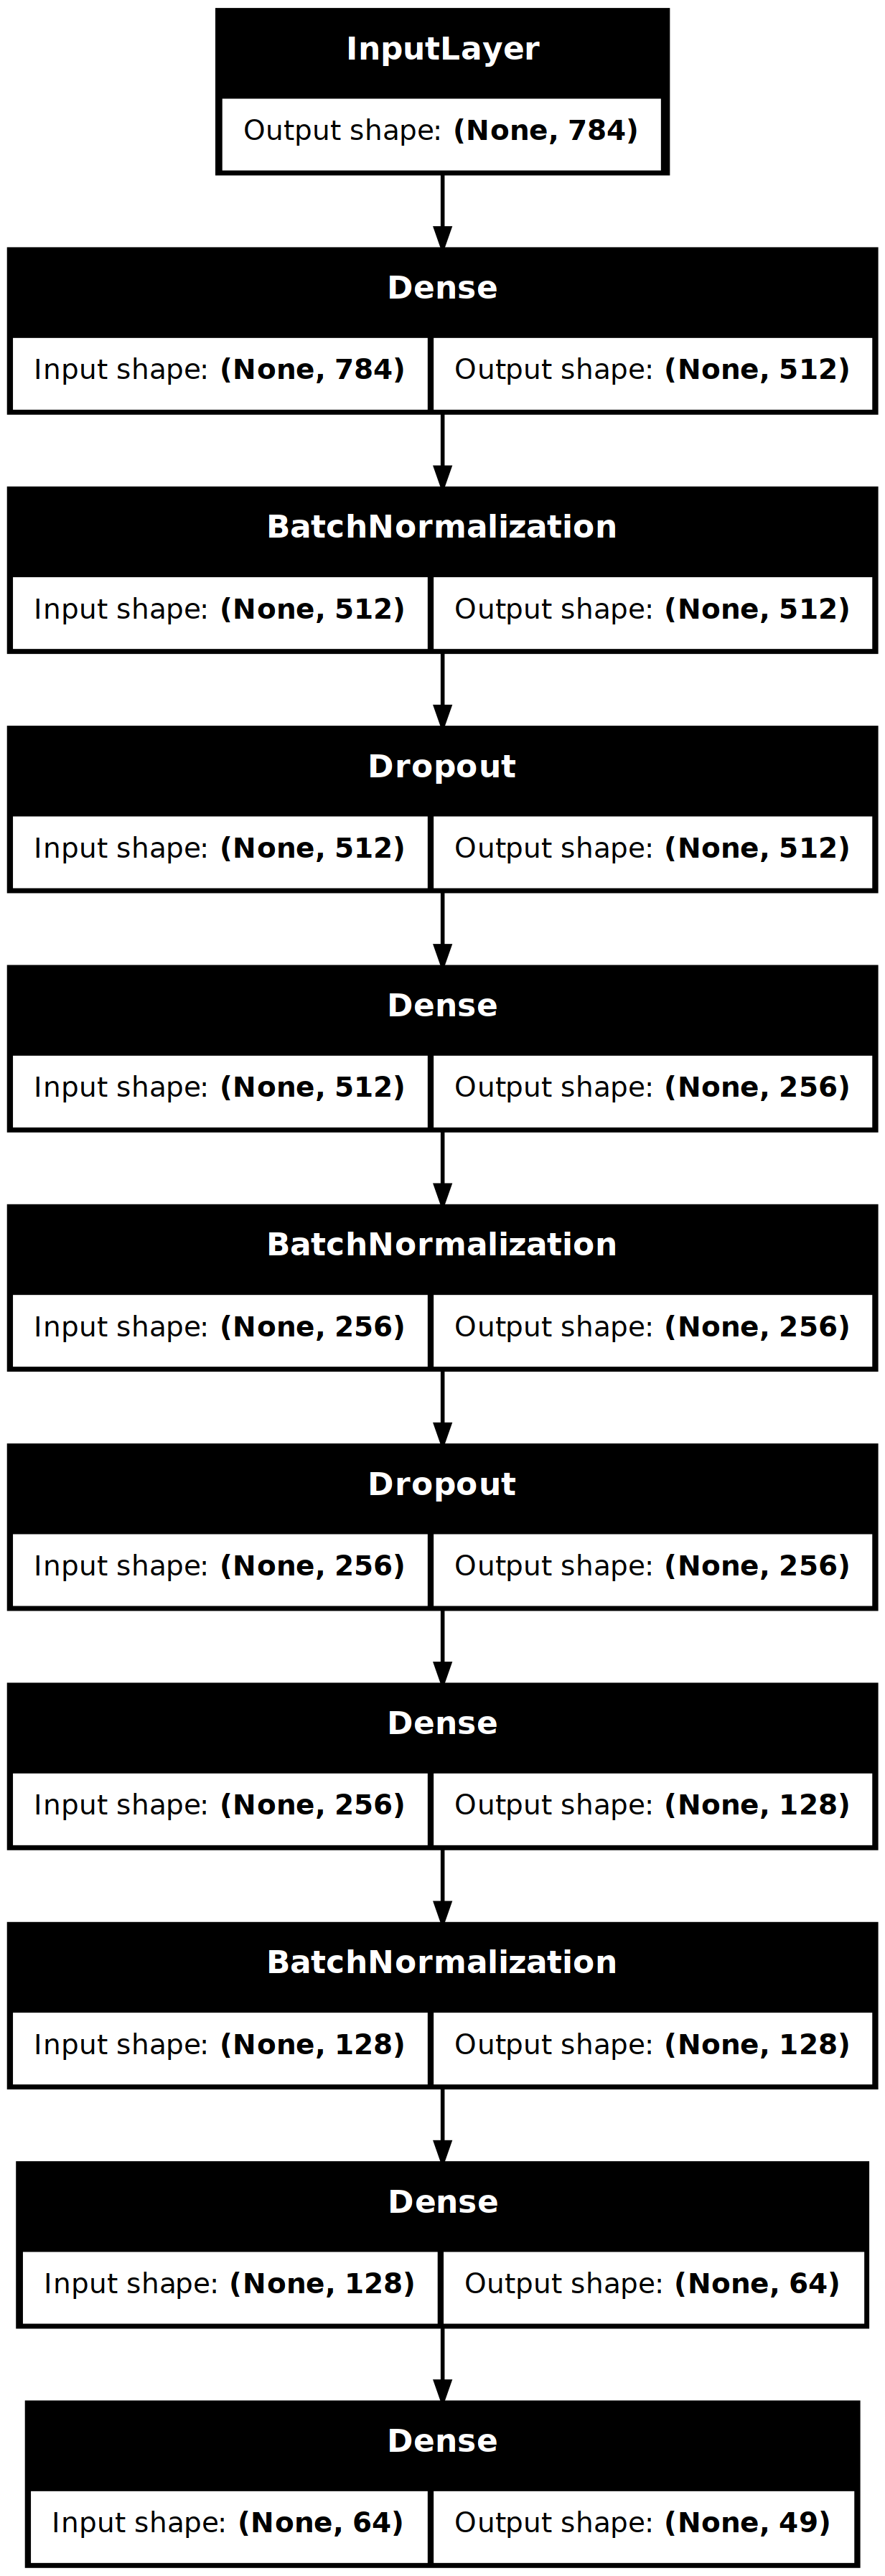

In [26]:
tf.keras.utils.plot_model(model_f, show_shapes=True)

In [37]:
logdir = os.path.join('logs/kuzushiji-49/', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))

In [38]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(os.path.join(logdir, 'model.keras'), save_best_only=True, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(logdir, update_freq=10)
]

In [39]:
# compile the model, make sure to add accuracy metric
model_f.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)

In [40]:
# train the model, make sure to use callbacks and validation dataset
model_f.fit(dataset, validation_data=val_dataset, epochs=20)

Epoch 1/20


/home/dron46/anaconda3/envs/tf/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:602: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
I0000 00:00:1715741685.517705    2226 service.cc:145] XLA service 0x6a3df030 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1715741685.518330    2226 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-05-15 12:54:45.611100: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-15 12:54:45.970260: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 107/2550 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.1301 - loss: 3.6882    

I0000 00:00:1715741689.274850    2226 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_slice_fusion_1', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1715741689.282313    2226 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2550/2550 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5305 - loss: 1.8784

I0000 00:00:1715741696.090231    2223 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_slice_fusion_1', 4 bytes spill stores, 4 bytes spill loads



2550/2550 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.5306 - loss: 1.8783 - val_accuracy: 0.8113 - val_loss: 0.6867
Epoch 2/20
2550/2550 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7464 - loss: 0.9401 - val_accuracy: 0.8425 - val_loss: 0.5656
Epoch 3/20
2550/2550 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7839 - loss: 0.7971 - val_accuracy: 0.8607 - val_loss: 0.5049
Epoch 4/20
2550/2550 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8025 - loss: 0.7213 - val_accuracy: 0.8759 - val_loss: 0.4497
Epoch 5/20
2550/2550 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8168 - loss: 0.6671 - val_accuracy: 0.8814 - val_loss: 0.4408
Epoch 6/20
2550/2550 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8278 - loss: 0.6254 - val_accuracy: 0.8874 - val_loss: 0.4155
Epoch 7/20
2550/2550 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8375 - loss: 0.5862 - val_accuracy: 0.8924 - val_loss: 0.3976
Epoch 8/20
2550/2550 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8438 - loss: 0.5607 - val_accura

In [41]:
model_f.evaluate(test_dataset)

1059/1059 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9175 - loss: 0.2987


[0.30060598254203796, 0.9166814088821411]

In [42]:
images = X_test.reshape(-1, 28, 28, 1) # normalize if needed

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


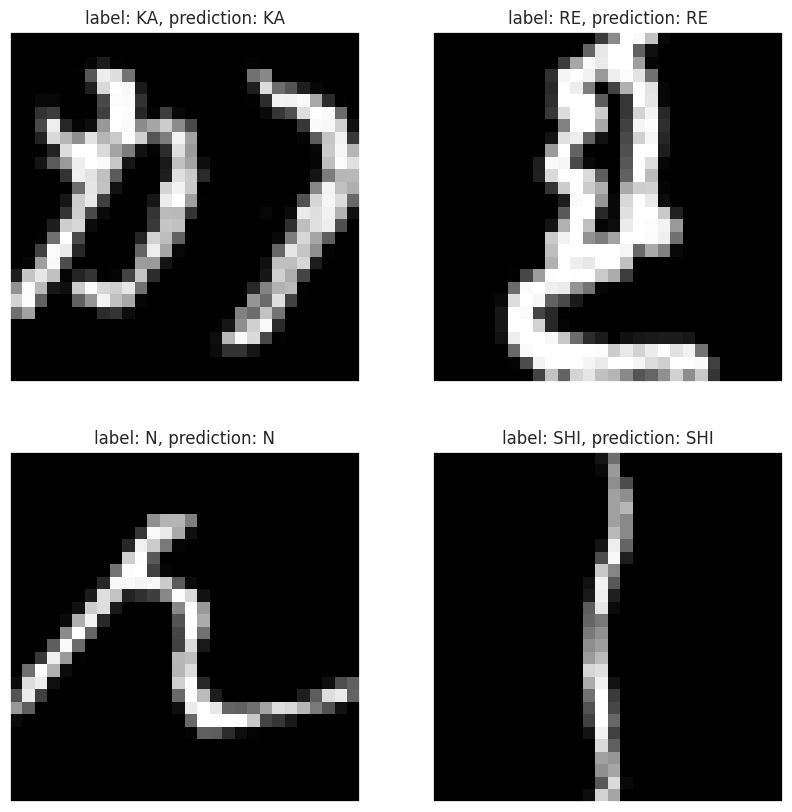

In [43]:
plot_grid_and_label(images, y_test, model_f, label_description=label_description)

In [44]:
y_pred = model_f.predict(X_test).argmax(axis=-1) # make predictions

2117/2117 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


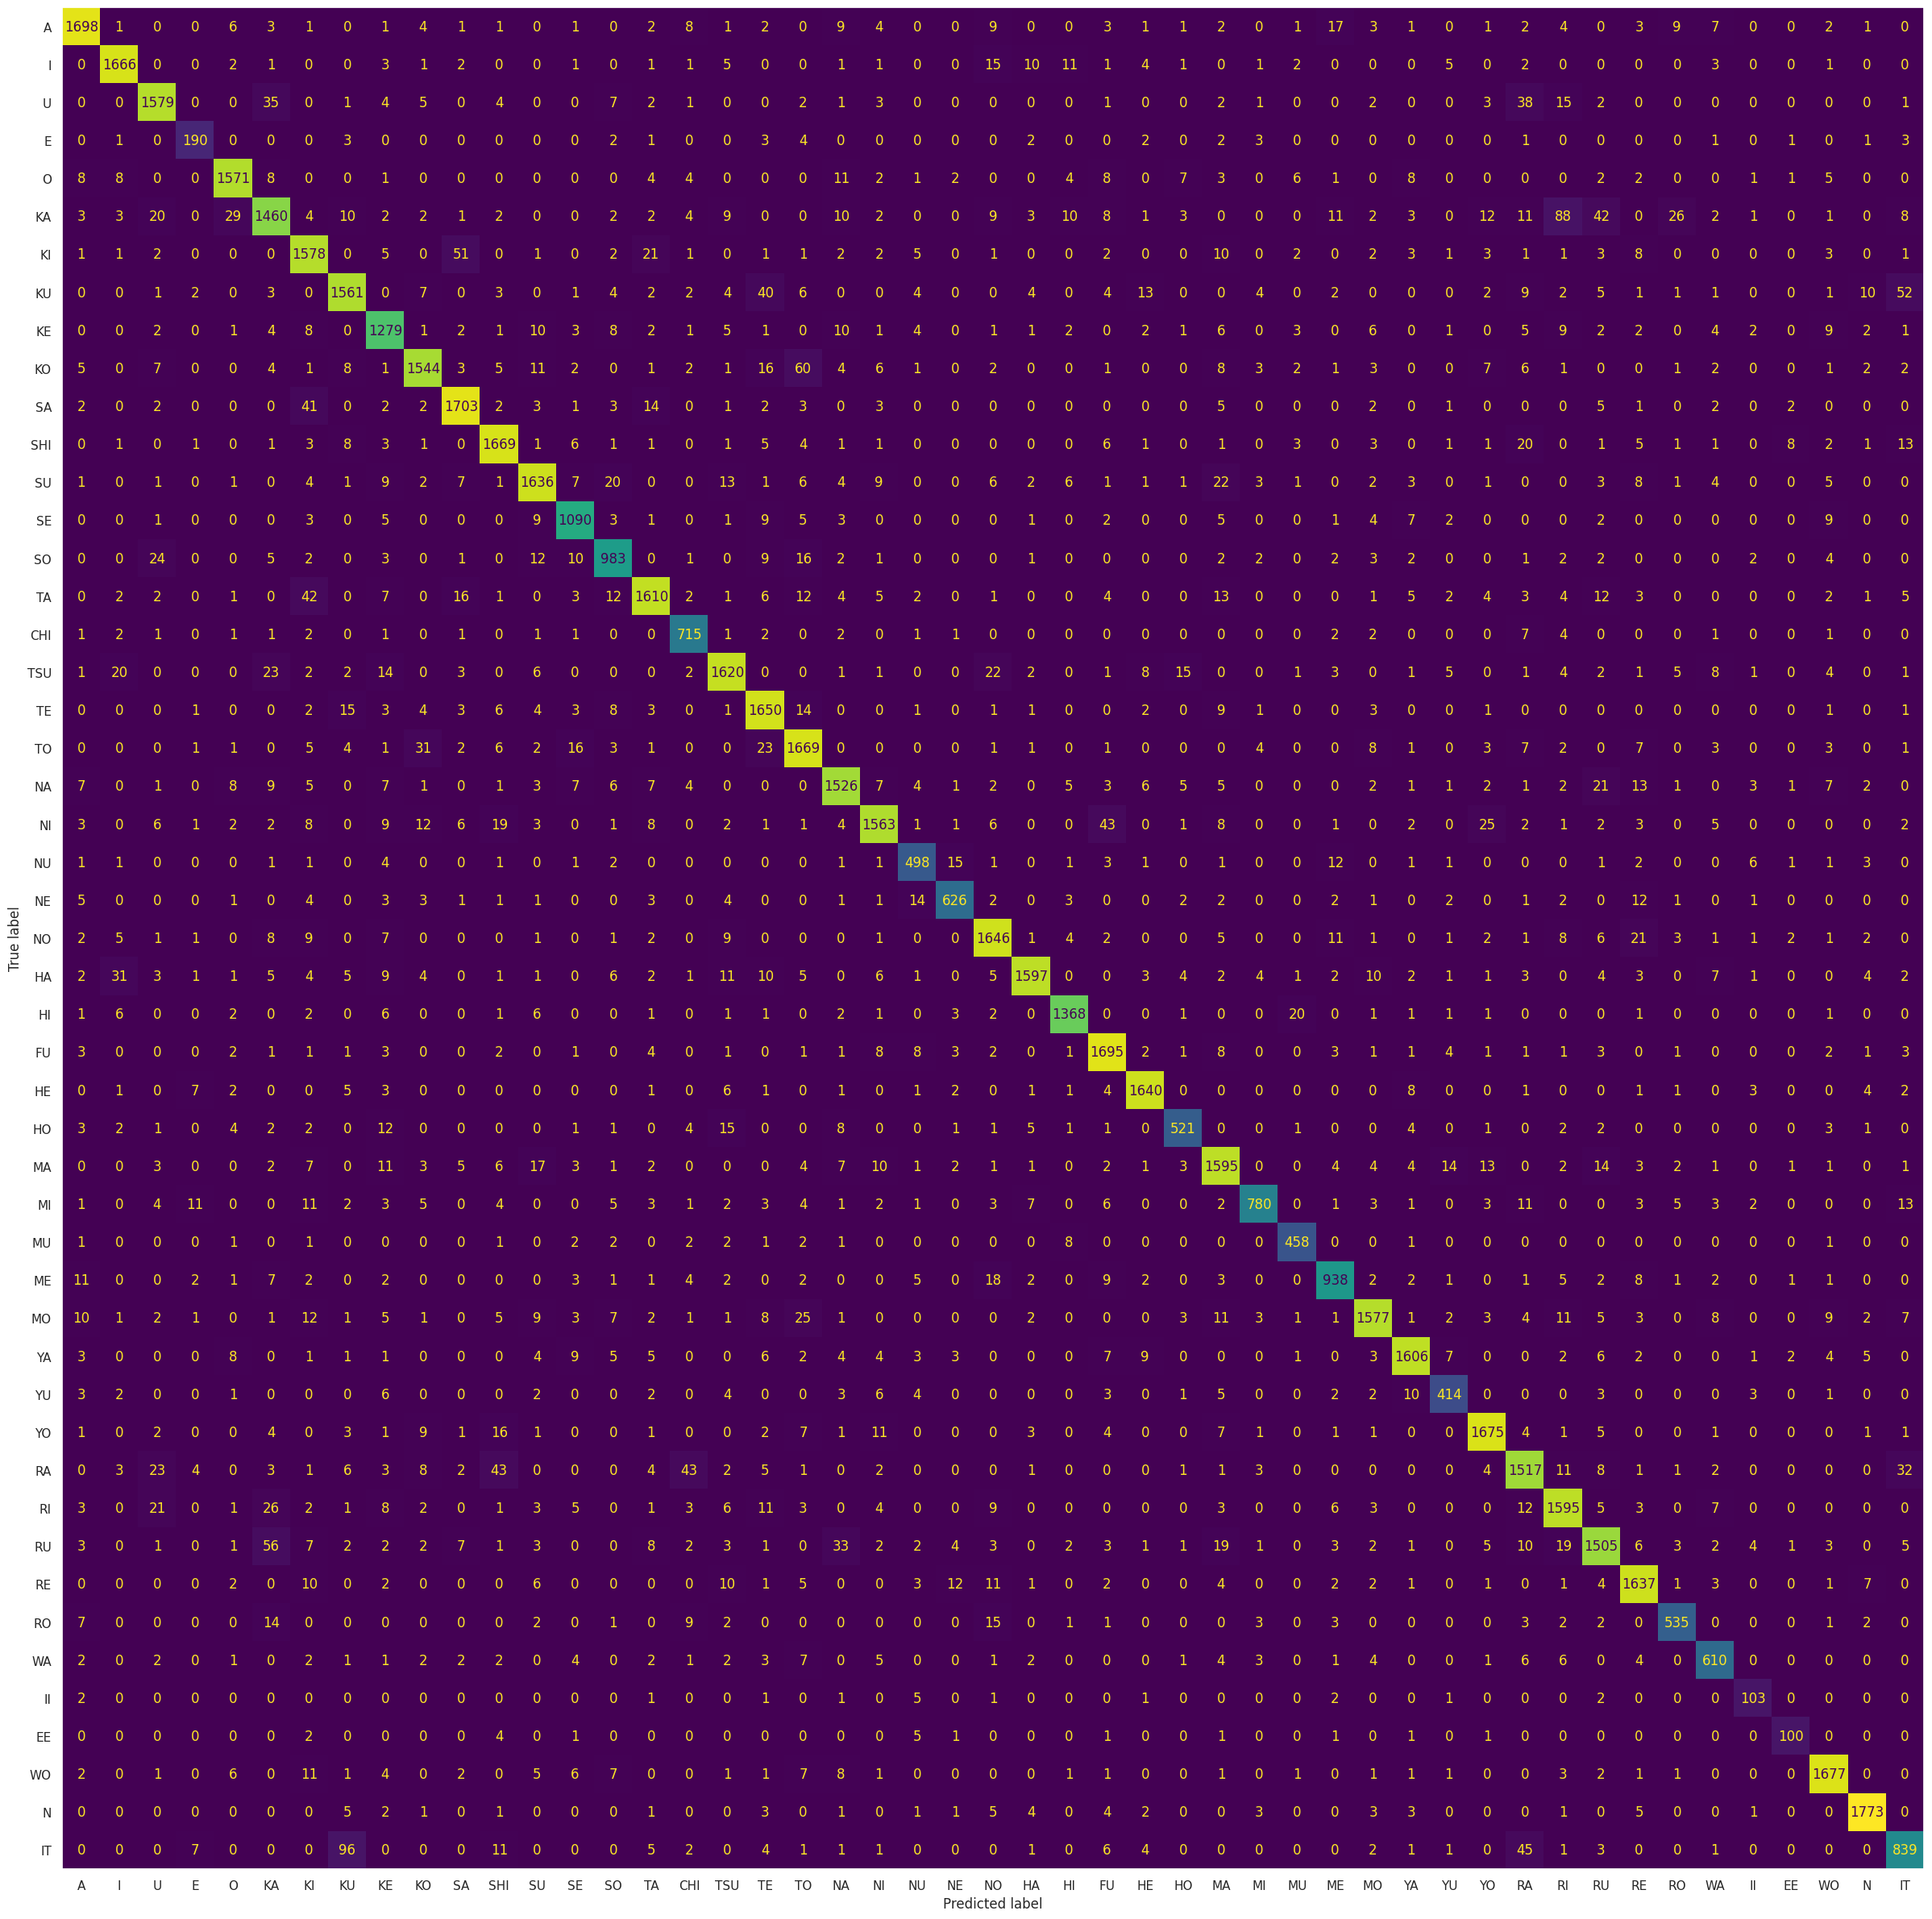

In [45]:
_, ax = plt.subplots(figsize=(30, 30))
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=label_description, ax=ax, colorbar=False)

##### Balanced accuracy

In [46]:
accuracy = y_test == y_pred
np.mean([np.mean(accuracy[y_test == i]) for i in range(49)])

0.9100806722784904

## Actual images
Use Conv2D layers with Dense layer on top

In [15]:
class_weights = sklearn.utils.class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

class_weight_dict = dict(enumerate(class_weights))

for class_label, weight in class_weight_dict.items():
    print(f'Weight for class {class_label}: {weight:.2f}')

Weight for class 0: 0.80
Weight for class 1: 0.79
Weight for class 2: 0.78
Weight for class 3: 6.22
Weight for class 4: 0.80
Weight for class 5: 0.78
Weight for class 6: 0.80
Weight for class 7: 0.78
Weight for class 8: 1.02
Weight for class 9: 0.78
Weight for class 10: 0.79
Weight for class 11: 0.78
Weight for class 12: 0.78
Weight for class 13: 1.15
Weight for class 14: 1.24
Weight for class 15: 0.78
Weight for class 16: 1.86
Weight for class 17: 0.79
Weight for class 18: 0.79
Weight for class 19: 0.79
Weight for class 20: 0.78
Weight for class 21: 0.79
Weight for class 22: 2.29
Weight for class 23: 1.93
Weight for class 24: 0.78
Weight for class 25: 0.80
Weight for class 26: 0.93
Weight for class 27: 0.81
Weight for class 28: 0.78
Weight for class 29: 2.32
Weight for class 30: 0.79
Weight for class 31: 1.53
Weight for class 32: 2.73
Weight for class 33: 1.43
Weight for class 34: 0.80
Weight for class 35: 0.79
Weight for class 36: 3.04
Weight for class 37: 0.78
Weight for class 38: 0

In [16]:
class_weights_tensor = tf.convert_to_tensor(list(class_weight_dict.values()), dtype=tf.float32)
def apply_class_weights(features, label):
    class_weight = tf.gather(class_weights_tensor, label)
    return features, label, class_weight

2024-05-17 12:04:51.292251: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-17 12:04:51.292385: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-17 12:04:51.292409: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-17 12:04:52.447784: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-17 12:04:52.447914: I external/local_xla/xla/stream_executor

In [17]:
# create train and validation datasets, these datasets should use 28x28x1 images
dataset = tf.data.Dataset.from_tensor_slices(
    (X_train, y_train))
dataset = dataset.map(apply_class_weights)
dataset = dataset.shuffle(buffer_size=1024)

val_dataset = tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices(X_val),
    tf.data.Dataset.from_tensor_slices(y_val)
))

test_dataset = tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices(X_test),
    tf.data.Dataset.from_tensor_slices(y_test)
)).batch(64)



In [18]:
dataset = dataset.map(lambda x, y, z: (tf.reshape(x, shape=(28, 28, 1)), y, z))
val_dataset = val_dataset.map(lambda x, y: (tf.reshape(x, shape=(28, 28, 1)), y))
test_dataset = test_dataset.map(lambda x, y: (tf.reshape(x, shape=(-1, 28, 28, 1)), y))

In [19]:
dataset = dataset.batch(64)
val_dataset = val_dataset.batch(64)

In [20]:
dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [21]:
test_dataset

<_MapDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [27]:
inputs = tf.keras.layers.Input((28, 28, 1 ), dtype=tf.float32, name="inputs")

x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, dilation_rate=1, padding="same", activation='relu')(inputs)
x = tf.keras.layers.BatchNormalization(name='bn0_1')(x)
x = tf.keras.layers.MaxPool2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, dilation_rate=1, padding="same",  activation='relu')(x)
x = tf.keras.layers.BatchNormalization(name='bn0_2')(x)
x = tf.keras.layers.MaxPool2D(pool_size=2)(x)
x = tf.keras.layers.Dropout(0.3)(x)

x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, dilation_rate=1, padding="same",  activation='relu')(x)
x = tf.keras.layers.BatchNormalization(name='bn0_3')(x)
x = tf.keras.layers.MaxPool2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, dilation_rate=1, padding="same",  activation='relu')(x)
x = tf.keras.layers.BatchNormalization(name='bn0_4')(x)
x = tf.keras.layers.MaxPool2D(pool_size=2)(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.BatchNormalization(name='bn1_1')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.BatchNormalization(name='bn1_2')(x)
x = tf.keras.layers.Dense(49)(x)

model = tf.keras.Model(inputs=inputs, outputs=x, name='conv_k49')

In [28]:
model.summary()

Model: "conv_k49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inputs (InputLayer)             │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn0_1 (BatchNormalization)      │ (None, 28, 28, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn0_2 (BatchNormalization)      │ (None, 14, 14, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn0_3 (BatchNormalization)      │ (None, 7, 7, 128)      │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 3, 3, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn0_4 (BatchNormalization)      │ (None, 3, 3, 128)      │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1_1 (BatchNormalization)      │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1_2 (BatchNormalization)      │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 49)             │         3,185 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 289,265 (1.10 MB)

 Trainable params: 288,113 (1.10 MB)

 Non-trainable params: 1,152 (4.50 KB)

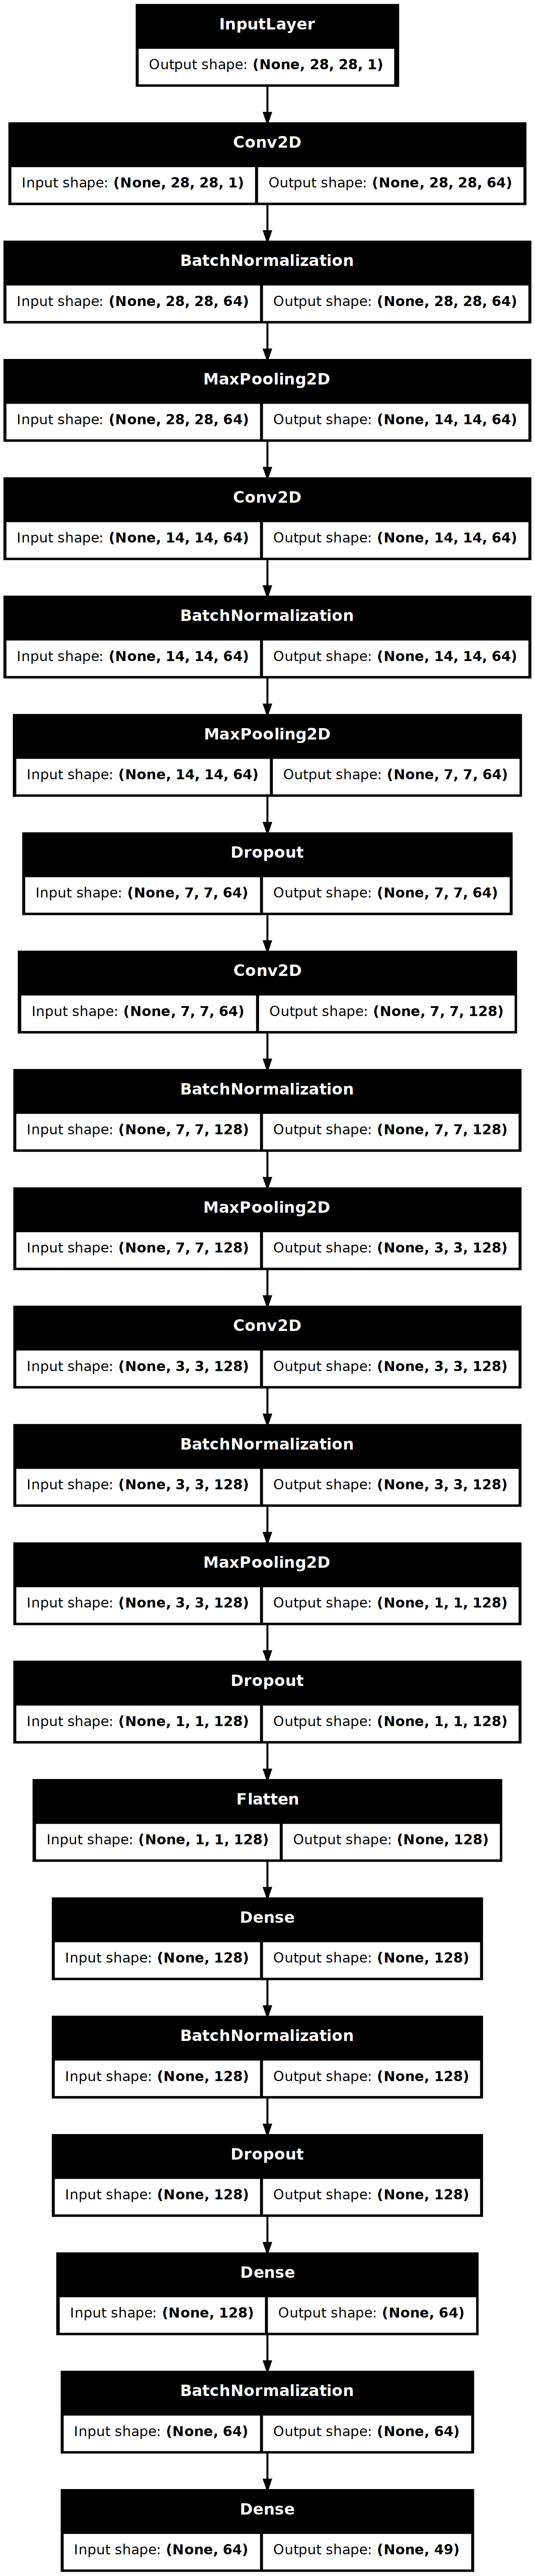

In [29]:
tf.keras.utils.plot_model(model,  show_shapes=True)

In [30]:
logdir = os.path.join('logs/kuzushiji-49/', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))

In [31]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(os.path.join(logdir, 'model.keras'), save_best_only=True, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(logdir, update_freq=10)
]

In [32]:
# compile the model, make sure to add accuracy metric
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)

In [34]:
# train the model, make sure to use callbacks and validation dataset
model.fit(dataset, batch_size=64, validation_data=val_dataset, epochs=20)

Epoch 1/20


I0000 00:00:1715911602.975369    6328 service.cc:145] XLA service 0x7fcec0001de0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1715911602.976705    6328 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-05-17 12:06:43.251016: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-17 12:06:44.398311: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


   2/2550 ━━━━━━━━━━━━━━━━━━━━ 2:26 57ms/step - accuracy: 0.0469 - loss: 4.7208   

I0000 00:00:1715911615.886099    6328 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2550/2550 ━━━━━━━━━━━━━━━━━━━━ 98s 31ms/step - accuracy: 0.3792 - loss: 2.4341 - val_accuracy: 0.8735 - val_loss: 0.4654
Epoch 2/20
2550/2550 ━━━━━━━━━━━━━━━━━━━━ 73s 28ms/step - accuracy: 0.7803 - loss: 0.7777 - val_accuracy: 0.9207 - val_loss: 0.2865
Epoch 3/20
2550/2550 ━━━━━━━━━━━━━━━━━━━━ 60s 24ms/step - accuracy: 0.8410 - loss: 0.5669 - val_accuracy: 0.9330 - val_loss: 0.2414
Epoch 4/20
2550/2550 ━━━━━━━━━━━━━━━━━━━━ 76s 30ms/step - accuracy: 0.8665 - loss: 0.4743 - val_accuracy: 0.9429 - val_loss: 0.2051
Epoch 5/20
2550/2550 ━━━━━━━━━━━━━━━━━━━━ 70s 27ms/step - accuracy: 0.8849 - loss: 0.4057 - val_accuracy: 0.9470 - val_loss: 0.1927
Epoch 6/20
2550/2550 ━━━━━━━━━━━━━━━━━━━━ 68s 27ms/step - accuracy: 0.8959 - loss: 0.3590 - val_accuracy: 0.9527 - val_loss: 0.1737
Epoch 7/20
2550/2550 ━━━━━━━━━━━━━━━━━━━━ 66s 26ms/step - accuracy: 0.9016 - loss: 0.3384 - val_accuracy: 0.9578 - val_loss: 0.1584
Epoch 8/20
2550/2550 ━━━━━━━━━━━━━━━━━━━━ 58s 23ms/step - accuracy: 0.9078 - loss: 0.32

In [35]:
model.evaluate(test_dataset)

1059/1059 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.9684 - loss: 0.1242


[0.12412227690219879, 0.9676204919815063]

In [36]:
images = X_test.reshape(-1, 28, 28, 1) # normalize if needed

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


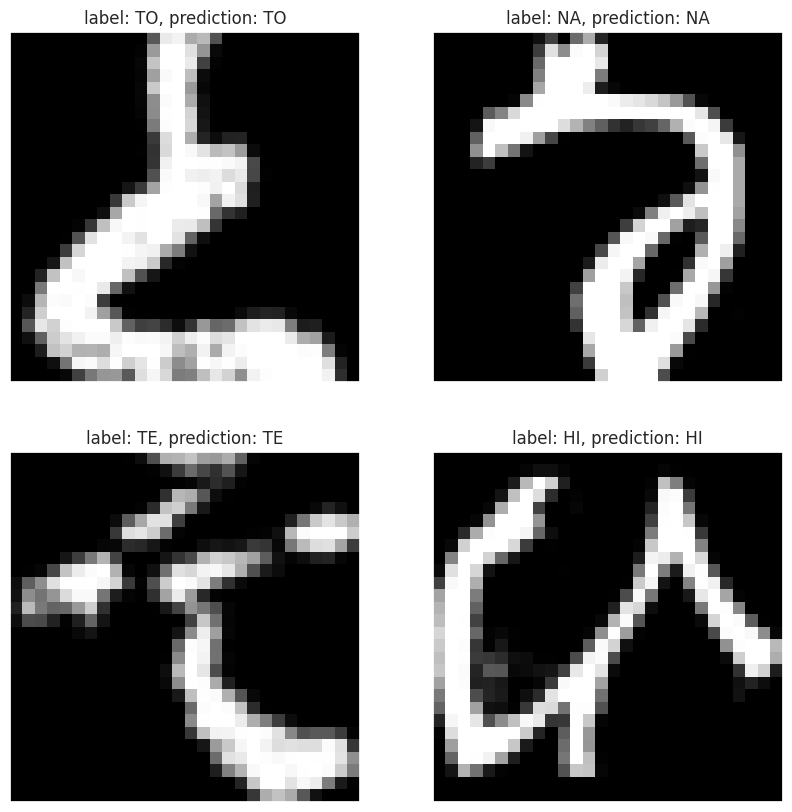

In [37]:
plot_grid_and_label(images, y_test, model, label_description=label_description, flatten_image=False)

In [38]:
X_test.shape

(67728, 784)

In [39]:
y_pred = model.predict(tf.reshape(X_test, (-1, 28, 28, 1))).argmax(axis=-1)

2117/2117 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step


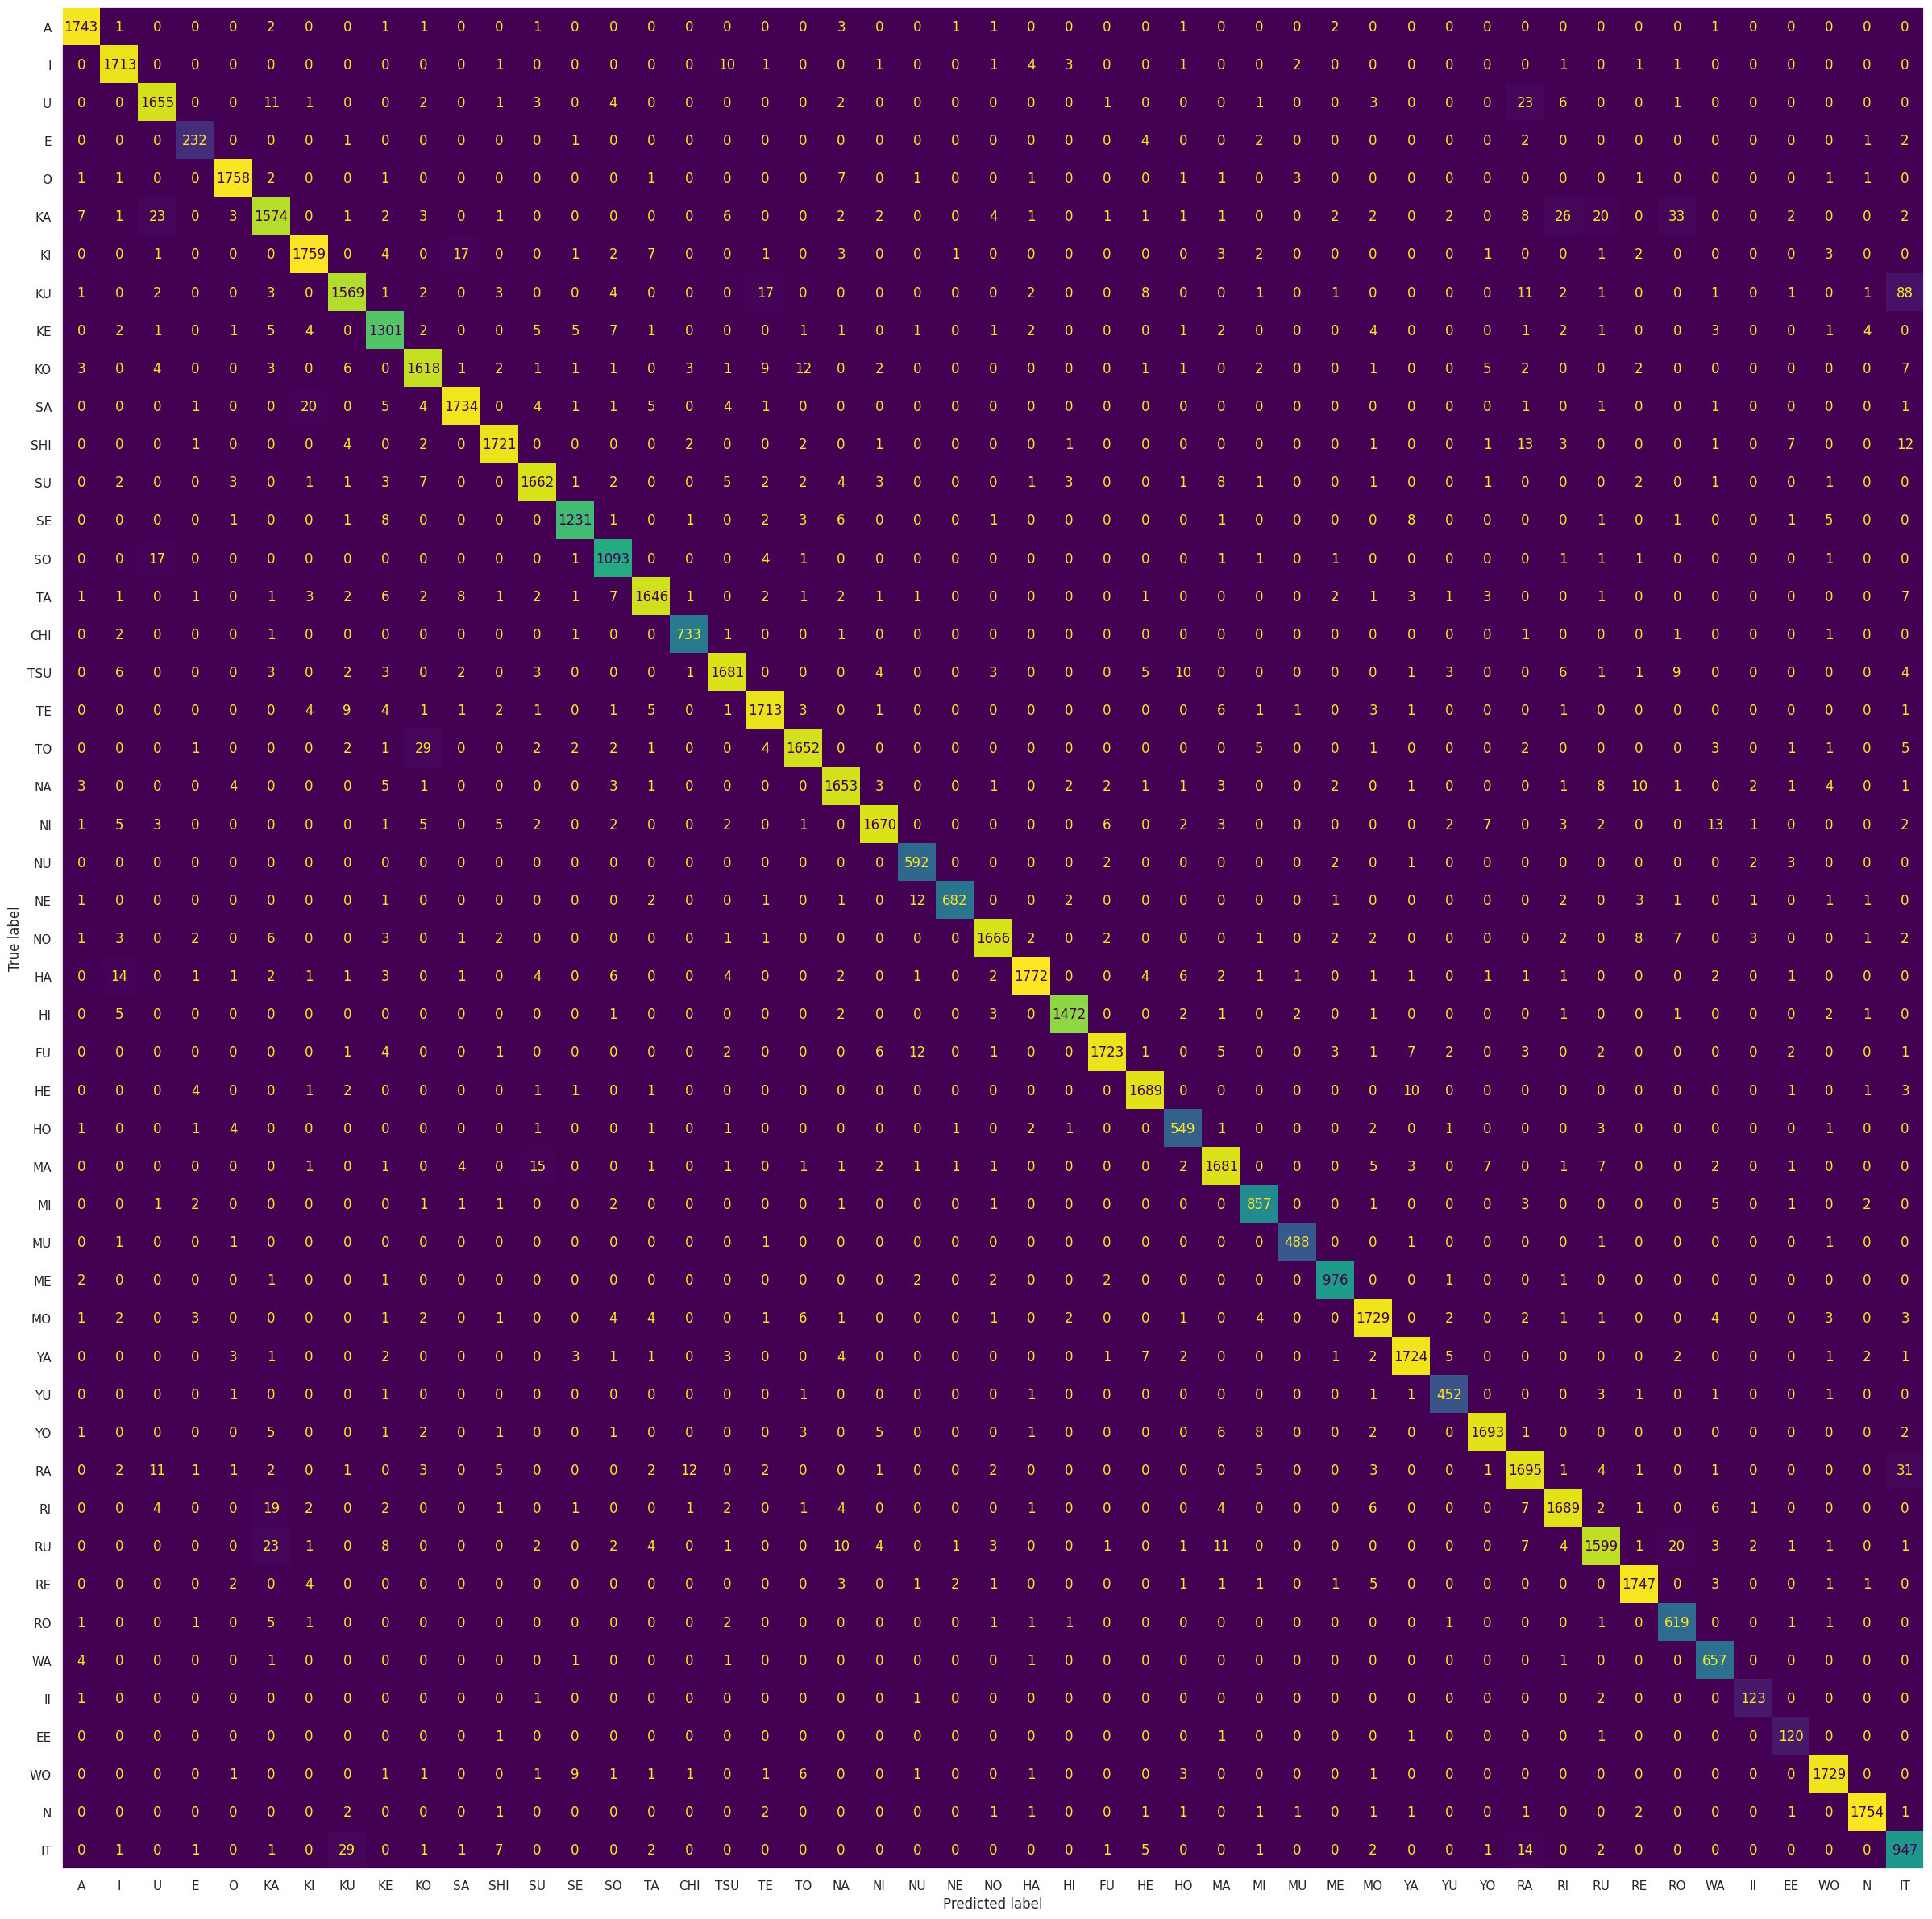

In [40]:
_, ax = plt.subplots(figsize=(30, 30))
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=label_description, ax=ax, colorbar=False)

##### Balanced accuracy

In [41]:
accuracy = y_test == y_pred
np.mean([np.mean(accuracy[y_test == i]) for i in range(49)])

0.968037725923784